In [9]:
import attr
import torch
import pandas as pd
import matplotlib.pyplot as plt



def get_all_phenotypes(population: Population) -> torch.Tensor:
    """Returns a tensor of all phenotypes in the population.

    Args:
        population (Population): The population object.

    Returns:
        torch.Tensor: A tensor of shape (n_individuals, n_traits) containing all phenotypes.
    """
    return torch.stack([individual.phenotype for individual in population.individuals])

def get_all_genetic_values(population: Population) -> torch.Tensor:
    """Returns a tensor of all genetic values in the population.

    Args:
        population (Population): The population object.

    Returns:
        torch.Tensor: A tensor of shape (n_individuals, n_traits) containing all genetic values.
    """
    return torch.stack([individual.genetic_values for individual in population.individuals])


@attr.s(auto_attribs=True)
class Individual:
    """Represents an individual in a population."""
    haplotypes: torch.Tensor  # Shape: (ploidy, n_chromosomes, n_loci_per_chr)
    phenotype: torch.Tensor = None
    genetic_values: torch.Tensor = None
    sex: str = None
    id: int = None
    mother_id: int = None
    father_id: int = None

    @property
    def allele_dosage(self):
        """Calculates the allele dosage from the haplotypes."""
        return self.haplotypes.sum(dim=0)  # Sum across the ploidy dimension


@attr.s(auto_attribs=True)
class Population:
    """Manages a collection of individuals."""
    individuals: list[Individual] = attr.Factory(list)
    sim_param: 'SimParam' = None

    def __len__(self):
        return len(self.individuals)
    
    def generate_random_founders(self, n_founders: int):
        """Generates a founder population with random haplotypes."""
        for i in range(n_founders):
            haplotypes = torch.randint(
                0, 2, (self.sim_param.ploidy, self.sim_param.n_chromosomes, self.sim_param.n_loci_per_chr)
            )
            individual = Individual(haplotypes=haplotypes, id=i + 1)
            self.individuals.append(individual)

    def set_phenotypes(self, varE: float):
        """Sets phenotypes for all individuals in the population."""
        for individual in self.individuals:
            genetic_value = self.calculate_genetic_value(individual)
            environmental_noise = torch.randn(1) * torch.sqrt(torch.tensor(varE))
            individual.phenotype = genetic_value + environmental_noise
            individual.genetic_values = genetic_value

    def calculate_genetic_value(self, individual: Individual):
        """Calculates the genetic value for an individual."""
        total_genetic_value = torch.tensor(0.0) # Initialize genetic value
        for trait in self.sim_param.traits:
            genetic_value = trait.mean 
            for chr in range(self.sim_param.n_chromosomes):
                for ploidy_idx in range(self.sim_param.ploidy):
                    for qtl_idx in range(trait.n_qtl_per_chr):
                        qtl_location = trait.qtl_locations[chr, ploidy_idx, qtl_idx]
                        allele_dosage = individual.allele_dosage[chr, qtl_location]
                        effect = trait.qtl_effects[chr, ploidy_idx, qtl_idx]
                        genetic_value += allele_dosage * effect
            total_genetic_value += genetic_value
        return total_genetic_value



@attr.s(auto_attribs=True)
class Trait:
    """Defines parameters for a trait."""
    mean: float
    variance: float
    n_qtl_per_chr: int 
    qtl_effects: torch.Tensor = None
    qtl_locations: torch.Tensor = None

    def generate_qtl_effects(self, n_chromosomes, ploidy,  n_loci_per_chr):
        """Generates QTL effects and their locations."""
        qtl_effects = torch.randn(n_chromosomes, ploidy, self.n_qtl_per_chr) * torch.sqrt(torch.tensor(self.variance))
        
        qtl_locations = []
        for _ in range(n_chromosomes):
            for _ in range(ploidy):
                qtl_locations.append(torch.randperm(n_loci_per_chr)[:self.n_qtl_per_chr])
                
        qtl_locations = torch.stack(qtl_locations).view(n_chromosomes, ploidy, self.n_qtl_per_chr)
        # Assert that qtl_effects and qtl_locations have the same shape

        assert qtl_effects.shape == qtl_locations.shape, "Shapes of qtl_effects and qtl_locations do not match"
        self.qtl_effects = qtl_effects
        self.qtl_locations = qtl_locations

@attr.s(auto_attribs=True)
class SimParam:
    """Stores global simulation parameters."""
    n_chromosomes: int = 10
    ploidy: int = 2
    traits: list[Trait] = attr.Factory(list)
    n_loci_per_chr: int = 100
    # ... (Other simulation parameters)

    def add_trait_A(self, mean: float, variance: float, n_qtl_per_chr: int):
        """Creates an additive trait and adds it to the simulation."""
        trait = Trait(mean=mean, variance=variance, n_qtl_per_chr=n_qtl_per_chr)
        trait.generate_qtl_effects(self.n_chromosomes, self.ploidy,  self.n_loci_per_chr) # Access SimParam attributes within the method
        self.traits.append(trait) 

# Simulation parameters
sim_param = SimParam(n_chromosomes=2, n_loci_per_chr=100, ploidy=2) # Create a population
population = Population(sim_param=sim_param)
# Generate 100 founders with 1000 loci per chromosome
population.generate_random_founders(n_founders=100)
# Generate Trait
# Add a trait 
sim_param.add_trait_A(mean=1.0, variance=1.0, n_qtl_per_chr=10)
# set phenotypes
population.set_phenotypes(varE=1)

# Accessing an individual:
individual = population.individuals[0]
# Accessing allele_dosage of an individual:
haplotype = individual.haplotypes
genotype = individual.allele_dosage
phenotype = individual.phenotype
geneticValue = individual.genetic_values
sim_param.traits[0].qtl_locations.shape

torch.Size([2, 2, 10])

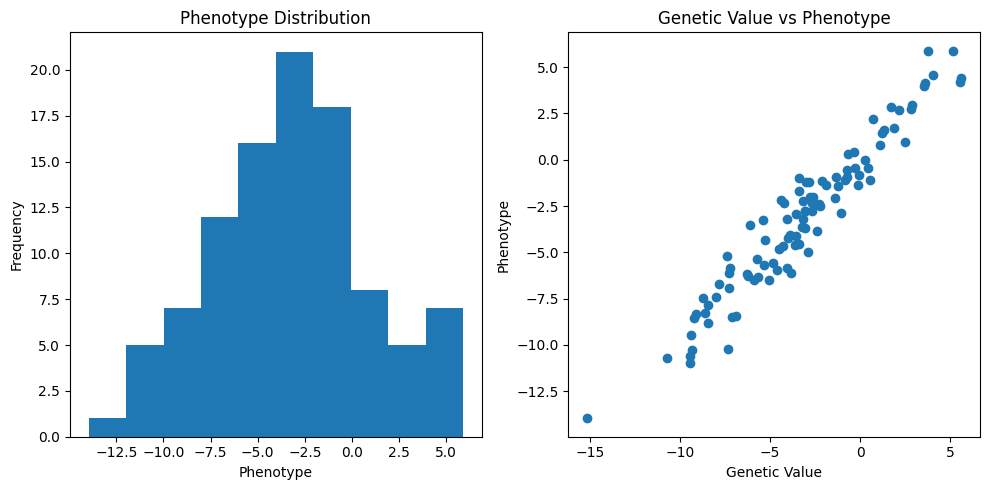

In [11]:

# Set phenotype
# population = set_phenotype(population, varE=1.0)
# Get all phenotypes and genetic values
phenotypes = get_all_phenotypes(population)
genetic_values = get_all_genetic_values(population)

# --- Plotting ---
plt.figure(figsize=(10, 5))

# Histogram of phenotypes
plt.subplot(1, 2, 1)
plt.hist(phenotypes.numpy(), bins=10)
plt.title("Phenotype Distribution")
plt.xlabel("Phenotype")
plt.ylabel("Frequency")

# Scatter plot of genetic values vs phenotypes
plt.subplot(1, 2, 2)
plt.scatter(genetic_values.numpy(), phenotypes.numpy())
plt.title("Genetic Value vs Phenotype")
plt.xlabel("Genetic Value")
plt.ylabel("Phenotype")

plt.tight_layout()
plt.show()

In [8]:
geneticValue

tensor(3.8526)

In [176]:
sim_param.traits[0].qtl_effects.shape

torch.Size([2, 4, 10])

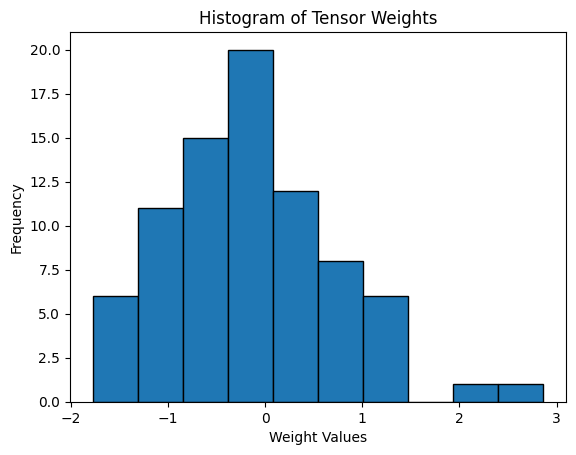

In [177]:
np_array = sim_param.traits[0].qtl_effects.flatten().numpy()

# Create a histogram
plt.hist(np_array, bins=10, edgecolor='black')

# Add titles and labels
plt.title('Histogram of Tensor Weights')
plt.xlabel('Weight Values')
plt.ylabel('Frequency')

# Show the plot
plt.show()
